# Research Question 10

10.	How do state tax policies (income tax, sales tax, property tax) differ between Colorado and Utah, and how do these differences impact residents and businesses?

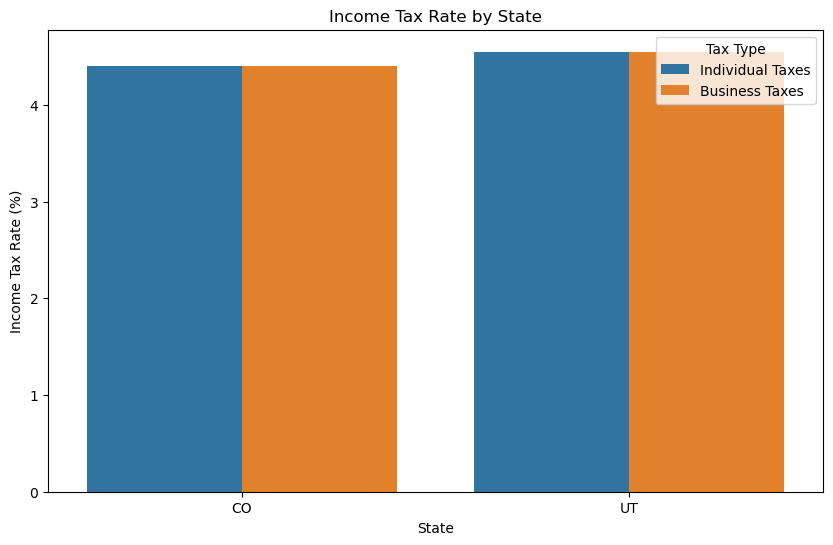

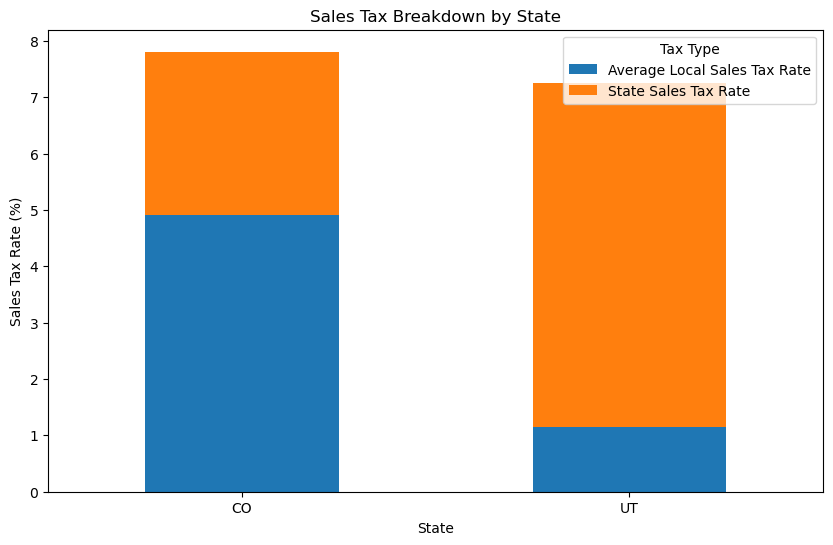

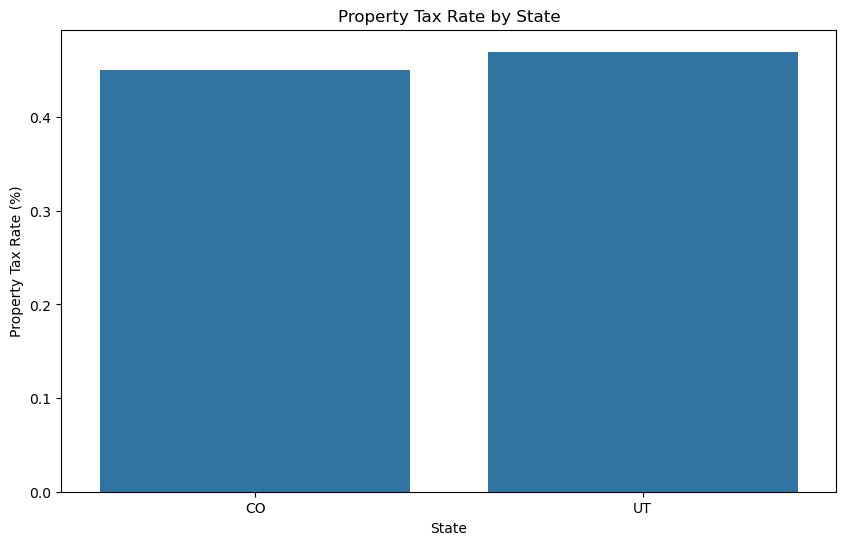

In [1]:
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import requests
import seaborn as sns

# Ensure results directory exists
output_dir = "../results/question_10"
os.makedirs(output_dir, exist_ok=True)

# Define URLs
url_co = "https://taxfoundation.org/location/colorado/"
url_ut = "https://taxfoundation.org/location/utah/"

### 1. Scrape Tax Data from Tax Foundation ###
def scrape_tax_data(url):
    response = requests.get(url)
    soup = bs(response.text, "html.parser")

    # Scrape relevant data
    taxes = soup.find_all("div", class_="data-boxes__item")
    # Extract Tax Group, Tax Item, Tax Value
    groups, items, values = [], [], []
    for tax in taxes:
        # Tax Group
        parent = tax.find_parent("div", class_=re.compile("tabs__content*"))
        group = parent.find("h3").text
        groups.append(group)
        # Tax Item
        item = tax.find("h5").text
        items.append(item)
        # Tax Value
        value = tax.find("span", class_="num").text
        values.append(value)

    # create dataframe
    tax_data = pd.DataFrame({
        "Group": groups,
        "Item": items,
        "Value": values
    })
    state = "CO" if "colorado" in url else "UT"
    tax_data["State"] = [state]*len(tax_data)
    tax_data = tax_data[["State", "Group", "Item", "Value"]]
    
    return tax_data

### 2. Process and Visualize Tax Data ###
def analyze_tax_data(url_co, url_ut):
    tax_data = pd.concat([scrape_tax_data(url_co), scrape_tax_data(url_ut)])
    tax_data = tax_data.reset_index(drop=True)

    # Income Tax
    df_it = tax_data[(tax_data["Item"]=="Top Individual Income Tax Rate")|(tax_data["Item"]=="Top Corporate Income Tax Rate")]
    df_it.loc[:,"Value"] = pd.to_numeric(df_it.loc[:,"Value"].str.replace("%", ""), errors="coerce")
    plt.figure(figsize=(10, 6))
    sns.barplot(x="State", y="Value", hue="Group", data=df_it)
    plt.title("Income Tax Rate by State")
    plt.xlabel("State")
    plt.ylabel("Income Tax Rate (%)")
    plt.legend(title="Tax Type")
    plt.savefig(f"{output_dir}/income_tax_comparison.png")
    plt.show()
    
    # Sales Tax
    df_st = tax_data[(tax_data["Item"]=="State Sales Tax Rate")|(tax_data["Item"]=="Average Local Sales Tax Rate")|(tax_data["Item"]=="Combined State and Average Local Sales Tax Rate")]
    df_st.loc[:,"Value"] = pd.to_numeric(df_st.loc[:,"Value"].str.replace("%", ""), errors="coerce")
    df_st = df_st.drop('Group', axis=1)
    df_st = df_st[df_st["Item"]!="Combined State and Average Local Sales Tax Rate"]
    df_st_pivot = df_st.pivot(index="State", columns="Item", values="Value")
    df_st_pivot.plot(kind="bar", stacked=True, figsize=(10, 6))
    plt.xlabel("State")
    plt.ylabel("Sales Tax Rate (%)")
    plt.title("Sales Tax Breakdown by State")
    plt.xticks(rotation=0)
    plt.legend(title="Tax Type")
    plt.savefig(f"{output_dir}/sales_tax_comparison.png")
    plt.show()

    # Property Tax
    df_pt = tax_data[tax_data["Item"]=="Property Taxes Paid as a Percentage of Owner-Occupied Housing Value"]
    df_pt.loc[:,"Value"] = pd.to_numeric(df_pt.loc[:,"Value"].str.replace("%", ""), errors="coerce")
    plt.figure(figsize=(10, 6))
    sns.barplot(x="State", y="Value", data=df_pt)
    plt.title("Property Tax Rate by State")
    plt.xlabel("State")
    plt.ylabel("Property Tax Rate (%)")
    plt.savefig(f"{output_dir}/property_tax_comparison.png")
    plt.show()

    return tax_data

# Run the analysis
tax_data = analyze_tax_data(url_co, url_ut)

## Before and After Snapshots of the Dataset

In [2]:
# before/after tax data (There is no differnce between before and after because it is just scraping)
tax_data

,State,Group,Item,Value
0,CO,Individual Taxes,Top Individual Income Tax Rate,4.40%
1,CO,Individual Taxes,State Local Individual Income Tax Collections ...,$1759
2,CO,Individual Taxes,State and Local Tax Burden,9.7%
3,CO,Business Taxes,Top Corporate Income Tax Rate,4.40%
4,CO,Business Taxes,State Business Tax Climate Index Ranking,32
5,CO,Sales Taxes,State Sales Tax Rate,2.90%
6,CO,Sales Taxes,Average Local Sales Tax Rate,4.91%
7,CO,Sales Taxes,Combined State and Average Local Sales Tax Rate,7.81%
8,CO,Sales Taxes,State and Local General Sales Tax Collections ...,$1547
9,CO,Sales Taxes,State Gasoline Tax Rate (cents per gallon),29.00¢
